Анализ объявлений о продаже автомобилей с сайтa eBay.
<br>**Цель:** определить средние цены популярных марок автомобилей и посмотреть, есть ли какая-либо корреляция со средним пробегом по маркам

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
cm = sns.light_palette("pink", as_cmap=True)

autos = pd.read_csv('data/autos.csv',encoding = 'Latin-1')
autos.shape

(50000, 20)

In [2]:
pd.options.display.max_rows=15
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50


Фрейм данных представляет собой смесь целочисленных и строковых типов данных.
Поскольку данные ценового столбца представлены в виде строк, может оказаться полезным преобразовать этот столбец в числовой тип данных.

In [3]:
nameMap = {'dateCrawled':'date_crawled', 'name':'name', 'seller':'seller', 'offerType':'offer_type', 'price':'price', 'abtest':'abtest',
         'vehicleType':'vehicle_type', 'yearOfRegistration':'registration_year',   'gearbox':'gearbox', 'powerPS':'power_ps', 'model':'model',
            'odometer':'odometer',    'monthOfRegistration':'registration_month', 'fuelType':'fuel_type', 'brand':'brand',
   'notRepairedDamage':'unrepaired_damage',   'dateCreated':'ad_created',     'nrOfPictures':'nr_of_pictures', 'postalCode':'postal_code',
            'lastSeen':'last_seen'}

autos.rename(mapper=nameMap, axis=1, inplace=True)

In [4]:
# Convert price & odometer to numeric values
autos['price']    = autos['price'].str.strip().str.replace('$','').str.replace(',','').astype(int)
autos['odometer'] = autos['odometer'].str.strip().str.replace('km','').str.replace(',','').astype(int)
autos.rename({'odometer':'odometer_km'}, axis=1, inplace=True)

### Исследование выбросов в `price` и `odometer_km`

In [5]:
autos['price'].unique().shape

(2357,)

In [6]:
autos['price'].describe()

count    5.000000e+04
mean     9.840044e+03
std      4.811044e+05
min      0.000000e+00
25%      1.100000e+03
50%      2.950000e+03
75%      7.200000e+03
max      1.000000e+08
Name: price, dtype: float64

In [7]:
autos['price'].value_counts().sort_index(ascending=False).head(10)

99999999    1
27322222    1
12345678    3
11111111    2
10000000    1
3890000     1
1300000     1
1234566     1
999999      2
999990      1
Name: price, dtype: int64

In [8]:
autos['price'].value_counts().sort_index(ascending=True).head(10)

0     1421
1      156
2        3
3        1
5        2
8        1
9        1
10       7
11       2
12       3
Name: price, dtype: int64

Выбросы в данных о ценах, которые надо удалить, находятся за пределами $350000.
<br>Также надо удалить 1421 объявления, оцененных в ноль.

In [9]:
autos = autos[autos['price'].between(1,350001)]

In [10]:
autos['odometer_km'].unique().shape

(13,)

In [11]:
autos['odometer_km'].describe()

count     48565.000000
mean     125770.101925
std       39788.636804
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: odometer_km, dtype: float64

In [12]:
autos['odometer_km'].value_counts().sort_index(ascending=True)

5000        836
10000       253
20000       762
30000       780
40000       815
50000      1012
60000      1155
70000      1217
80000      1415
90000      1734
100000     2115
125000     5057
150000    31414
Name: odometer_km, dtype: int64

В столбце `odometer_km` не будет каких-либо заметных выбросов.
<br>Поскольку существует только 13 уникальных значений, вероятно, выбираются из предопределенных параметров на веб-сайте.

#### Теперь будут исследованы столбцы `date_crawled`, `ad_created` и `last_seen`.

In [13]:
autos['date_crawled'].str[:10].value_counts(normalize=True, dropna=False).sort_index(ascending=True)

2016-03-05    0.025327
2016-03-06    0.014043
2016-03-07    0.036014
2016-03-08    0.033296
2016-03-09    0.033090
2016-03-10    0.032184
2016-03-11    0.032575
                ...   
2016-04-01    0.033687
2016-04-02    0.035478
2016-04-03    0.038608
2016-04-04    0.036487
2016-04-05    0.013096
2016-04-06    0.003171
2016-04-07    0.001400
Name: date_crawled, Length: 34, dtype: float64

In [14]:
autos['ad_created'].str[:10].value_counts(normalize=True, dropna=False).sort_index(ascending=True)

2015-06-11    0.000021
2015-08-10    0.000021
2015-09-09    0.000021
2015-11-10    0.000021
2015-12-05    0.000021
2015-12-30    0.000021
2016-01-03    0.000021
                ...   
2016-04-01    0.033687
2016-04-02    0.035149
2016-04-03    0.038855
2016-04-04    0.036858
2016-04-05    0.011819
2016-04-06    0.003253
2016-04-07    0.001256
Name: ad_created, Length: 76, dtype: float64

Некоторые объявления довольно старые (до 9 месяцев), однако большинство объявлений попадают в период обхода.

In [15]:
autos['last_seen'].str[:10].value_counts(normalize=True, dropna=False).sort_index(ascending=True)

2016-03-05    0.001071
2016-03-06    0.004324
2016-03-07    0.005395
2016-03-08    0.007413
2016-03-09    0.009595
2016-03-10    0.010666
2016-03-11    0.012375
                ...   
2016-04-01    0.022794
2016-04-02    0.024915
2016-04-03    0.025203
2016-04-04    0.024483
2016-04-05    0.124761
2016-04-06    0.221806
2016-04-07    0.131947
Name: last_seen, Length: 34, dtype: float64

In [16]:
autos['registration_year'].describe()

count    48565.000000
mean      2004.755421
std         88.643887
min       1000.000000
25%       1999.000000
50%       2004.000000
75%       2008.000000
max       9999.000000
Name: registration_year, dtype: float64

По-видимому, в столбце `registration_year` есть некоторые нечестные значения года, так как максимальный год составляет 9999, а минимальный-1000. Эти значения являются выбросами и не имеют никакого смысла.

In [17]:
autos['registration_year'].value_counts().sort_index()

1000    1
1001    1
1111    1
1800    2
1910    5
1927    1
1929    1
       ..
4800    1
5000    4
5911    1
6200    1
8888    1
9000    1
9999    3
Name: registration_year, Length: 95, dtype: int64

Поскольку очень небольшое число перечисленных лет регистрации автомобилей составляет <1900 и существует большой разрыв в годах, эти вероятные выбросы могут быть удалены. Кроме того, любое транспортное средство с регистрационным годом выше 2016 года является ложным, поскольку автомобили не могут быть зарегистрированы после того, как создан список.

In [18]:
# Удалить годы регистрации выбросов
autos = autos[autos['registration_year'].between(1900,2016)]

autos['registration_year'].value_counts(normalize=True).head(20)

2000    0.067608
2005    0.062895
1999    0.062060
2004    0.057904
2003    0.057818
2006    0.057197
2001    0.056468
          ...   
2011    0.034768
2010    0.034040
1996    0.029412
2012    0.028063
1995    0.026285
2016    0.026135
2013    0.017202
Name: registration_year, Length: 20, dtype: float64

## Изучение брендов по цене
Рассмотрим среднюю цену наиболее популярных 15 брендов, представленных в нашем наборе данных, чтобы выявить любые тенденции.

In [19]:
popBrands = autos['brand'].value_counts().head(15).index

In [20]:
brandPriceData = {}
for b in popBrands:
    brandPrices = autos.loc[autos['brand'] == b,'price']
    brandPriceData[b] = int(brandPrices.mean())

In [21]:
avgBrandPrices = pd.Series(brandPriceData)
df = pd.DataFrame(avgBrandPrices, columns=['Mean Price']).sort_values(by=['Mean Price'],ascending=False)
df.style.background_gradient(cmap=cm)

,Mean Price
audi,9336
mercedes_benz,8628
bmw,8332
skoda,6368
volkswagen,5402
nissan,4743
seat,4397
mazda,4112
citroen,3779
ford,3749


Основываясь на нашем анализе, можно сделать вывод, что немецкие марки роскошных автомобилей, такие как Audi, Mercedes Benz и BMW, как правило, имеют самую высокую цену на eBay в период ползания. Это имеет смысл, поскольку роскошные автомобили дороже, чем стандартные коммерческие марки, такие как Mazda или Ford.


## Изучение брендов по пробегу
Рассмотрим средний пробег тех же 15 самых популярных марок. Это позволит легко сравнивать среднюю цену и средний пробег автомобилей различных марок.

In [22]:
brandMileData = {}
for b in popBrands:
    brandMiles = autos.loc[autos['brand'] == b,'odometer_km']
    brandMileData[b] = int(brandMiles.mean())

In [23]:
brandMileData_series = pd.Series(brandMileData)
df['Mean Mileage'] = brandMileData_series
df.style.background_gradient(cmap=cm)

,Mean Price,Mean Mileage
audi,9336,129157
mercedes_benz,8628,130788
bmw,8332,132572
skoda,6368,110848
volkswagen,5402,128707
nissan,4743,118330
seat,4397,121131
mazda,4112,124464
citroen,3779,119694
ford,3749,124266


Исходя из стандартных отклонений, пробег бренда варьируется гораздо больше, чем данные о ценах по маркам. Более дорогие автомобили, по-видимому, имеют несколько более высокий пробег по сравнению с более дешевыми автомобилями. Это может быть связано с тем, что владельцы автомобилей лучше заботятся о своих роскошных автомобилях, или с тем, что роскошные автомобили изготавливаются с более качественными компонентами, что продлевает срок службы автомобиля.


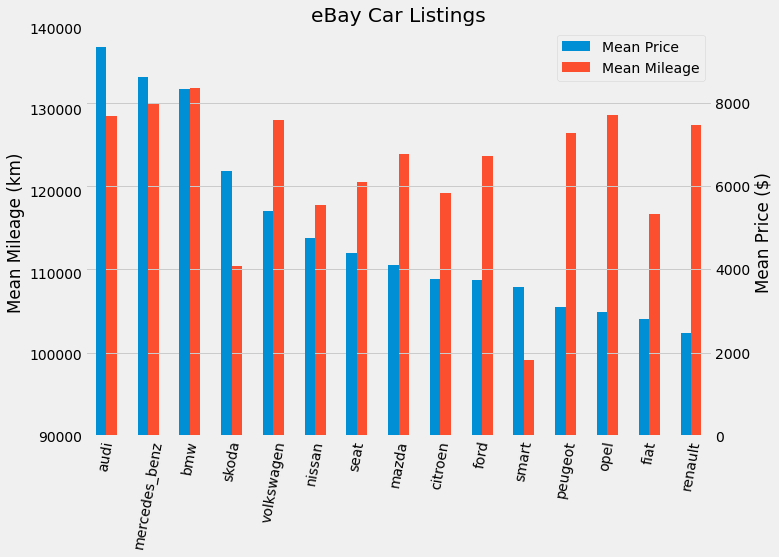

In [24]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
style.use('fivethirtyeight')

ax = df.plot(kind= 'bar', secondary_y= 'Mean Price', rot= 80, figsize=(10,7), ylim=(90000, 140000), mark_right=False)
ax.set_ylabel('Mean Mileage (km)')
ax.right_ax.set_ylabel('Mean Price ($)')
ax.set_title('eBay Car Listings')
plt.show()

In [25]:
# Корреляция Пирсона между mean price & mean mileage - Luxury German Cars
df.loc[['audi','mercedes_benz','bmw'], :].corr()

,Mean Price,Mean Mileage
Mean Price,1.000000,-0.966777
Mean Mileage,-0.966777,1.000000


In [26]:
# Корреляция Пирсона между mean price & mean mileage - Non-Luxury Cars
df.iloc[3:, :].corr()

,Mean Price,Mean Mileage
Mean Price,1.000000,-0.244942
Mean Mileage,-0.244942,1.000000


Учитывая только самые дорогие немецкие марки автомобилей (Audi, Mercedes Benz, BMW), кажется, что их перечисленные значения уменьшаются по отношению к более высоким пробегам. Это согласуется с интуицией, поскольку аналогичный автомобиль с более высоким пробегом будет означать, что автомобиль использовался больше, что приведет к более низкой цене листинга. Эта обратная корреляция подтверждается большим отрицательным коэффициентом Пирсона (Р = -0,97).

Остальные автомобили в списке не имеют четкой тенденции в отношении их указанной цены и пробега. Коэффициент Пирсона (p = -0.24) предполагает очень слабую отрицательную корреляцию между ценой и пробегом. Это отсутствие корреляции может быть связано с тем, что продавцы имеют разные мнения об относительной стоимости различных марок автомобилей не класса люкс. Кроме того, другие факторы, кроме пробега, вероятно, оказывают влияние на ценообразование автомобилей.

Направление, выбранное для исследования, представляло собой анализ средней цены и среднего пробега 15 самых популярных марок автомобилей в наборе данных. Было установлено,что немецкие марки роскошных автомобилей, как правило, имеют самую высокую цену, причем их цены снижаются с увеличением пробега. Остальные не роскошные, популярные марки автомобилей не демонстрировали никакой определенной тенденции в отношении корреляции между ценой и пробегом в одиночку.